In [1]:
from data import Data
from base_types import DataType
import json
from utils import milliseconds_to_date

usd_name = 'BUSD'
token_name='BTC'
start_str = milliseconds_to_date(1642003500000) + ' UTC+8'
end_str = milliseconds_to_date(1654003499999 + 1) + ' UTC+8'
data = Data(token_name+usd_name, DataType.INTERVAL_1MINUTE, start_str=start_str, end_str=end_str, is_futures=True)
print(data.start_time())
print(data.end_time())

1642003500000
1654003499999


In [3]:
base_path = '.\\log\\{}_start_{}_end_{}_'.format(token_name+usd_name, data.start_time(), data.end_time())
trade_info_path = base_path + 'trade_info.json'
vertices_path = base_path + 'vertices.json'

with open(trade_info_path, 'r') as f:
    json_data = f.read()
    trade_info = json.loads(json_data)

with open(vertices_path, 'r') as f:
    json_data = f.read()
    vertices = json.loads(json_data)

print(trade_info.keys())
print(vertices.keys())

dict_keys(['buy_time', 'buy_price', 'sell_time', 'sell_price'])
dict_keys(['top_time', 'top_value', 'bottom_time', 'bottom_value'])


In [4]:
import numpy as np
import pandas as pd

df = data.data
df['TR'] = df[['high', 'low']].apply(lambda x: x['high'] - x['low'], axis=1)
top_idx = -1
bottom_idx = -1
top_time = vertices['top_time']
top_value = vertices['top_value']
bottom_time = vertices['bottom_time']
bottom_value = vertices['bottom_value']

# earn = target_sell_price - current_price
# target_sell_price = the first sell_price which is not NaN after now
# sell_price = Nan if low > last_bottom else min(high, last_bottom)
# buy_price = Nan if high < last_top else max(low, last_top)

new_col = ['last_top', 'step_after_top', 'last_bottom', 'step_after_bottom','is_up', 'cycle_step', 'buy_price', 'sell_price']
df = pd.concat([df, 
    pd.DataFrame(columns=new_col)], sort=False)

def fun(x):
    global top_idx, bottom_idx
    open_time = x['open_time']

    # Update top_idx and bottom_idx
    if top_idx + 1 < len(top_time) and open_time >= int(top_time[top_idx + 1]) + 60000 * 3:
        top_idx += 1

    if bottom_idx + 1 < len(bottom_time) and open_time >= int(bottom_time[bottom_idx + 1]) + 60000 * 3:
        bottom_idx += 1
    
    # Get last top and bottom
    if top_idx >= 0:
        last_top = top_value[top_idx]
        step_after_top = (open_time - top_time[top_idx]) / 60000
    else:
        last_top = np.nan
        step_after_top = np.nan
        
    if bottom_idx >= 0:
        last_bottom = bottom_value[bottom_idx]
        step_after_bottom = (open_time - bottom_time[bottom_idx]) / 60000
    else:
        last_bottom = np.nan
        step_after_bottom = np.nan
    
    # Get is_up and cycle_step
    is_up = 1 if step_after_top > step_after_bottom else 0
    cycle_step = step_after_top - step_after_bottom
    cycle_step = cycle_step if cycle_step >= 0 else -cycle_step

    buy_price = max(x['low'], last_top) if x['high'] >= last_top else np.nan
    sell_price = min(x['high'], last_bottom) if x['low'] <= last_bottom else np.nan

    return last_top, step_after_top, last_bottom, step_after_bottom, is_up, cycle_step, buy_price, sell_price

df[new_col] = df.apply(
    lambda x: fun(x), axis=1, result_type="expand")
    
df.head(10)

,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price
0,1.642004e+12,43605.9,43634.7,43557.5,43557.5,16.010,1.642004e+12,6.978678e+05,327.0,5.781,252014.2966,77.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,1.642004e+12,43557.4,43557.4,43446.0,43465.4,27.281,1.642004e+12,1.186358e+06,685.0,7.875,342447.4372,111.4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,1.642004e+12,43465.4,43472.8,43432.1,43459.3,21.134,1.642004e+12,9.183308e+05,318.0,10.003,434603.9132,40.7,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1.642004e+12,43459.3,43485.7,43451.4,43474.8,16.116,1.642004e+12,7.005642e+05,264.0,4.645,201918.0717,34.3,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,1.642004e+12,43474.8,43483.1,43444.9,43478.2,14.811,1.642004e+12,6.437641e+05,328.0,9.645,419224.8576,38.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,1.642004e+12,43483.1,43524.3,43468.7,43517.4,16.370,1.642004e+12,7.119822e+05,264.0,8.577,373030.6541,55.6,NaN,NaN,43432.1,3.0,0.0,NaN,NaN,NaN
6,1.642004e+12,43515.9,43526.0,43509.5,43511.4,6.578,1.642004e+12,2.862532e+05,129.0,2.685,116850.4010,16.5,NaN,NaN,43432.1,4.0,0.0,NaN,NaN,NaN
7,1.642004e+12,43511.3,43511.3,43470.6,43470.6,9.535,1.642004e+12,4.145910e+05,180.0,5.446,236776.5899,40.7,NaN,NaN,43432.1,5.0,0.0,NaN,NaN,NaN
8,1.642004e+12,43470.7,43487.5,43470.6,43474.0,4.691,1.642004e+12,2.039666e+05,172.0,2.603,113177.6827,16.9,NaN,NaN,43432.1,6.0,0.0,NaN,NaN,NaN
9,1.642004e+12,43474.0,43487.8,43468.7,43468.7,15.424,1.642004e+12,6.705767e+05,142.0,6.964,302775.9558,19.1,43526.0,3.0,43432.1,7.0,0.0,4.0,NaN,NaN


In [5]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_assert_volume', 'number_of_trades', 'taker_buy_volume',
       'taker_buy_quote_asset_volume', 'TR', 'last_top', 'step_after_top',
       'last_bottom', 'step_after_bottom', 'is_up', 'cycle_step', 'buy_price',
       'sell_price'],
      dtype='object')

In [6]:
new_ave_of_base = {
    'MA': 'close',
    'ATR': 'TR',
    'AQAV': 'quote_assert_volume',
    'AT': 'number_of_trades',
    'ATBQAV': 'taker_buy_quote_asset_volume',
    'ACS': 'cycle_step'
    }
cycles = [4, 16, 64, 256]
for ave in new_ave_of_base:
    for cc in cycles:
        df[ave + str(cc)] = df[new_ave_of_base[ave]].rolling(cc).mean()

df.tail(10)

,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,...,AT64,AT256,ATBQAV4,ATBQAV16,ATBQAV64,ATBQAV256,ACS4,ACS16,ACS64,ACS256
199990,1.654003e+12,31689.0,31695.0,31673.8,31692.7,72.606,1.654003e+12,2.300467e+06,547.0,32.360,...,469.171875,366.109375,816618.421800,751206.587694,716242.002711,597817.895599,1.75,3.7500,3.468750,3.355469
199991,1.654003e+12,31692.7,31700.0,31684.1,31684.1,21.203,1.654003e+12,6.719382e+05,308.0,8.503,...,471.375000,366.562500,862247.127775,698154.481981,718513.182845,597360.352122,1.50,3.3750,3.468750,3.355469
199992,1.654003e+12,31684.1,31684.1,31663.9,31663.9,27.429,1.654003e+12,8.687344e+05,266.0,1.311,...,467.171875,366.781250,612396.010425,604188.726831,700219.467730,596709.371701,1.00,3.0000,3.468750,3.343750
199993,1.654003e+12,31663.9,31674.2,31663.9,31674.1,27.977,1.654003e+12,8.859833e+05,326.0,16.392,...,468.625000,367.574219,463814.280225,520895.930656,704322.439955,597081.857572,1.00,2.6250,3.468750,3.332031
199994,1.654003e+12,31670.7,31670.7,31670.0,31670.1,4.637,1.654003e+12,1.468545e+05,58.0,2.795,...,465.281250,366.652344,229653.066275,511875.462994,705043.096023,594791.832651,2.00,2.5000,3.531250,3.343750
199995,1.654003e+12,31670.6,31670.6,31659.9,31666.0,16.669,1.654003e+12,5.278149e+05,197.0,7.000,...,465.359375,366.468750,217690.372950,521761.008050,705254.613647,595044.498689,2.00,2.1250,3.531250,3.339844
199996,1.654003e+12,31666.0,31678.0,31665.9,31673.9,14.631,1.654003e+12,4.634052e+05,209.0,10.872,...,466.687500,365.562500,293396.493425,436663.265919,707207.641320,595854.651495,2.00,1.8750,3.468750,3.335938
199997,1.654003e+12,31674.0,31726.9,31673.5,31705.8,101.510,1.654003e+12,3.218329e+06,1040.0,59.163,...,472.281250,368.593750,632452.019875,541342.518338,711539.491564,602498.436903,2.00,1.6250,3.406250,3.332031
199998,1.654003e+12,31705.7,31707.5,31696.1,31697.4,21.229,1.654003e+12,6.730093e+05,230.0,3.882,...,472.421875,368.812500,641088.364675,502103.232006,710253.192348,601982.069026,1.00,1.5625,3.390625,3.328125
199999,1.654003e+12,31697.4,31697.5,31661.5,31676.3,44.458,1.654003e+12,1.408301e+06,539.0,13.646,...,476.187500,370.292969,693738.758200,518391.028988,707758.925731,602507.754064,1.00,1.5625,3.375000,3.324219


In [7]:
last_sell_price = np.nan
last_buy_price = np.nan
def target_sell_price(x):
    global last_sell_price, last_buy_price
    if not pd.isna(x['sell_price']):
        last_sell_price = x['sell_price']

    if not pd.isna(x['buy_price']):
        last_buy_price = x['buy_price']

    return last_buy_price, last_sell_price

df[['target_buy_price', 'target_sell_price']] = df.iloc[::-1].apply(
    lambda x: target_sell_price(x), axis=1, result_type="expand").iloc[::-1]

# Time of the saving earn is one step ahead the true buy/sell time
df['earn_if_buy'] = df['target_sell_price'].shift(-1) - df['buy_price'].shift(-1)
df['earn_if_sell'] = df['sell_price'].shift(-1) - df['target_buy_price'].shift(-1)

df.head()

,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,...,ATBQAV64,ATBQAV256,ACS4,ACS16,ACS64,ACS256,target_buy_price,target_sell_price,earn_if_buy,earn_if_sell
0,1.642004e+12,43605.9,43634.7,43557.5,43557.5,16.010,1.642004e+12,6.978678e+05,327.0,5.781,...,NaN,NaN,NaN,NaN,NaN,NaN,43514.6,43432.1,NaN,NaN
1,1.642004e+12,43557.4,43557.4,43446.0,43465.4,27.281,1.642004e+12,1.186358e+06,685.0,7.875,...,NaN,NaN,NaN,NaN,NaN,NaN,43514.6,43432.1,NaN,NaN
2,1.642004e+12,43465.4,43472.8,43432.1,43459.3,21.134,1.642004e+12,9.183308e+05,318.0,10.003,...,NaN,NaN,NaN,NaN,NaN,NaN,43514.6,43432.1,NaN,NaN
3,1.642004e+12,43459.3,43485.7,43451.4,43474.8,16.116,1.642004e+12,7.005642e+05,264.0,4.645,...,NaN,NaN,NaN,NaN,NaN,NaN,43514.6,43432.1,NaN,NaN
4,1.642004e+12,43474.8,43483.1,43444.9,43478.2,14.811,1.642004e+12,6.437641e+05,328.0,9.645,...,NaN,NaN,NaN,NaN,NaN,NaN,43514.6,43432.1,NaN,NaN


In [8]:
df[['buy_price', 'sell_price', 'target_buy_price', 'target_sell_price', 'earn_if_buy', 'earn_if_sell']].head(30)

,buy_price,sell_price,target_buy_price,target_sell_price,earn_if_buy,earn_if_sell
0,NaN,NaN,43514.6,43432.1,NaN,NaN
1,NaN,NaN,43514.6,43432.1,NaN,NaN
2,NaN,NaN,43514.6,43432.1,NaN,NaN
3,NaN,NaN,43514.6,43432.1,NaN,NaN
4,NaN,NaN,43514.6,43432.1,NaN,NaN
5,NaN,NaN,43514.6,43432.1,NaN,NaN
6,NaN,NaN,43514.6,43432.1,NaN,NaN
7,NaN,NaN,43514.6,43432.1,NaN,NaN
8,NaN,NaN,43514.6,43432.1,NaN,NaN
9,NaN,NaN,43514.6,43432.1,NaN,-82.5


In [61]:
full_buy = df[pd.isna(df['buy_price']) & (~pd.isna(df['buy_price'].shift(-1)))].copy()
full_buy.drop(['open_time', 'close_time', 'volume', 'taker_buy_volume', 'buy_price', 'sell_price', 
    'target_buy_price', 'target_sell_price', 'earn_if_sell'], axis=1, inplace=True)
full_buy.drop(full_buy[pd.isna(full_buy['MA256'])].index, inplace=True)
full_buy.head(10)

,open,high,low,close,quote_assert_volume,number_of_trades,taker_buy_quote_asset_volume,TR,last_top,step_after_top,...,AT256,ATBQAV4,ATBQAV16,ATBQAV64,ATBQAV256,ACS4,ACS16,ACS64,ACS256,earn_if_buy
278,43650.0,43664.3,43650.0,43664.3,163537.4856,78.0,93475.0419,14.3,43671.5,3.0,...,163.726562,100284.258750,129335.041575,133488.901047,200344.204180,1.75,1.7500,2.859375,3.058594,233.0
301,43860.0,43872.8,43858.1,43867.5,163752.0256,67.0,30090.1270,14.7,43979.7,13.0,...,174.839844,57306.276575,227407.350794,247390.721777,222248.157649,6.00,3.6250,2.671875,3.097656,87.9
308,43917.7,43919.7,43905.5,43919.7,96998.4244,180.0,55240.0441,14.2,43931.0,3.0,...,175.328125,75398.690250,143327.262313,244052.488191,222242.436005,1.25,3.1875,2.562500,3.074219,46.0
310,43909.1,43912.6,43904.5,43912.6,37368.4204,44.0,15105.2589,8.1,43931.0,5.0,...,175.449219,73285.595125,103786.661044,241435.950359,222601.283281,1.25,3.1875,2.500000,3.058594,46.0
317,43968.1,43980.0,43965.1,43971.3,516845.3896,120.0,225085.3675,14.9,43984.0,3.0,...,176.703125,208004.383500,132193.745956,252417.369173,224316.986415,4.25,2.8125,2.593750,3.109375,-7.0
344,43861.5,43875.6,43861.1,43872.5,891083.5976,140.0,765787.5665,14.5,44004.7,17.0,...,213.226562,465172.613550,420131.917650,511833.745903,282850.698652,6.50,1.8750,2.734375,3.066406,-126.0
358,43777.8,43803.6,43777.8,43785.2,324879.2628,93.0,206688.3310,25.8,43805.2,5.0,...,212.460938,160864.079025,253964.144175,431195.832087,284281.460943,1.25,3.7500,2.703125,3.050781,-55.0
367,43799.7,43799.8,43789.5,43789.5,5255.0681,18.0,2058.2301,10.3,43817.9,8.0,...,206.468750,59276.587600,145432.404794,421184.670191,276126.912048,4.50,2.8125,2.531250,3.109375,46.6
369,43794.6,43794.7,43788.9,43788.9,82107.9727,31.0,8408.5824,5.8,43808.9,4.0,...,205.453125,9559.415500,103635.937938,417492.964816,275242.244378,3.00,2.5625,2.546875,3.089844,46.6
378,43832.2,43860.4,43831.1,43860.4,102894.6283,61.0,80231.3993,29.3,43861.4,3.0,...,200.890625,40458.448450,73415.856919,417776.555334,271183.151062,5.50,3.9375,2.812500,3.105469,-5.9


## Standardization

All price divided by close.

ATR and TR divided by close

AT and number_of_trades divided by number_of_trades

All volume divided by quote assert volume

In [19]:
full_buy.columns

Index(['open', 'high', 'low', 'close', 'quote_assert_volume',
       'number_of_trades', 'taker_buy_quote_asset_volume', 'TR', 'last_top',
       'step_after_top', 'last_bottom', 'step_after_bottom', 'is_up',
       'cycle_step', 'MA4', 'MA16', 'MA64', 'MA256', 'ATR4', 'ATR16', 'ATR64',
       'ATR256', 'AQAV4', 'AQAV16', 'AQAV64', 'AQAV256', 'AT4', 'AT16', 'AT64',
       'AT256', 'ATBQAV4', 'ATBQAV16', 'ATBQAV64', 'ATBQAV256', 'ACS4',
       'ACS16', 'ACS64', 'ACS256', 'earn_if_buy'],
      dtype='object')

In [62]:
atr_cols = ['ATR4', 'ATR16', 'ATR64', 'ATR256']
price_cols = ['open', 'high', 'low', 'close', 'TR', 'last_top', 'last_bottom', 'MA4', 'MA16', 'MA64', 'MA256']
trade_cols = ['number_of_trades', 'AT4', 'AT16', 'AT64', 'AT256']
volumn_cols = ['quote_assert_volume', 'taker_buy_quote_asset_volume', 'AQAV4', 'AQAV16', 'AQAV64', 
    'AQAV256', 'ATBQAV4', 'ATBQAV16', 'ATBQAV64', 'ATBQAV256']

full_buy.dropna(axis=0, how='any', inplace=True)
full_buy['earn_if_buy'] = full_buy['earn_if_buy'].div(full_buy['last_top'], axis=0)
full_buy[atr_cols] = full_buy[atr_cols].div(full_buy['TR'], axis=0)
full_buy[price_cols] = full_buy[price_cols].div(full_buy['close'], axis=0)
full_buy[trade_cols] = full_buy[trade_cols].div(full_buy['number_of_trades'], axis=0)
full_buy[volumn_cols] = full_buy[volumn_cols].div(full_buy['quote_assert_volume'], axis=0)

In [63]:
full_buy.drop(['close', 'quote_assert_volume', 'number_of_trades'], axis=1, inplace=True)
full_buy.head(10)

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,...,AT256,ATBQAV4,ATBQAV16,ATBQAV64,ATBQAV256,ACS4,ACS16,ACS64,ACS256,earn_if_buy
278,0.999673,1.000000,0.999673,0.571582,0.000327,1.000165,3.0,0.999079,4.0,0.0,...,2.099058,0.613219,0.790859,0.816259,1.225066,1.75,1.7500,2.859375,3.058594,0.005335
301,0.999829,1.000121,0.999786,0.183754,0.000335,1.002558,13.0,0.998140,7.0,1.0,...,2.609550,0.349958,1.388730,1.510764,1.357224,6.00,3.6250,2.671875,3.097656,0.001999
308,0.999954,1.000000,0.999677,0.569494,0.000323,1.000257,3.0,0.999515,4.0,0.0,...,0.974045,0.777319,1.477625,2.516046,2.291196,1.25,3.1875,2.562500,3.074219,0.001047
310,0.999920,1.000000,0.999816,0.404225,0.000184,1.000419,5.0,0.999677,6.0,0.0,...,3.987482,1.961164,2.777390,6.460962,5.956936,1.25,3.1875,2.500000,3.058594,0.001047
317,0.999927,1.000198,0.999859,0.435498,0.000339,1.000289,3.0,0.998481,8.0,0.0,...,1.472526,0.402450,0.255770,0.488381,0.434012,4.25,2.8125,2.593750,3.109375,-0.000159
344,0.999749,1.000071,0.999740,0.859389,0.000331,1.003013,17.0,0.997474,4.0,1.0,...,1.523047,0.522030,0.471484,0.574395,0.317423,6.50,1.8750,2.734375,3.066406,-0.002863
358,0.999831,1.000420,0.999831,0.636200,0.000589,1.000457,5.0,0.999201,4.0,1.0,...,2.284526,0.495150,0.781719,1.327249,0.875037,1.25,3.7500,2.703125,3.050781,-0.001256
367,1.000233,1.000235,1.000000,0.391666,0.000235,1.000649,8.0,0.998920,4.0,1.0,...,11.470486,11.279890,27.674695,80.148280,52.544878,4.50,2.8125,2.531250,3.109375,0.001063
369,1.000130,1.000132,1.000000,0.102409,0.000132,1.000457,4.0,0.998934,6.0,0.0,...,6.627520,0.116425,1.262191,5.084682,3.352199,3.00,2.5625,2.546875,3.089844,0.001064
378,0.999357,1.000000,0.999332,0.779743,0.000668,1.000023,3.0,0.998301,7.0,0.0,...,3.293289,0.393203,0.713505,4.060237,2.635542,5.50,3.9375,2.812500,3.105469,-0.000135


In [56]:
# np.mean(full_buy['earn_if_buy'])
# full_buy[pd.isna(full_buy['taker_buy_quote_asset_volume'])]
# full_buy.tail(30)

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,...,AT256,ATBQAV4,ATBQAV16,ATBQAV64,ATBQAV256,ACS4,ACS16,ACS64,ACS256,earn_if_buy
199628,1.000191,1.000333,1.000000,0.588315,0.000333,1.000505,5.0,1.000019,3.0,1.0,...,1.727479,0.519893,1.045338,1.064852,0.902701,1.75,2.0625,3.078125,3.062500,-0.000486
199635,0.999863,1.000000,0.999692,0.646384,0.000308,1.000562,5.0,0.999965,7.0,0.0,...,2.135363,0.879006,1.345293,2.161534,1.805816,1.75,2.1875,3.015625,3.054688,0.000562
199640,0.999619,1.000121,0.999033,0.607950,0.001088,1.000365,4.0,0.998170,7.0,0.0,...,0.618773,0.277007,0.255902,0.358604,0.301831,3.00,2.1250,2.890625,3.085938,-0.000333
199666,0.999762,1.000044,0.999762,0.599591,0.000283,1.001438,9.0,0.999267,5.0,1.0,...,2.863048,2.613737,1.694923,2.391846,2.435795,3.75,3.7500,2.937500,3.136719,0.002612
199674,1.000013,1.000016,0.999851,0.595078,0.000165,1.000212,3.0,0.997962,9.0,0.0,...,2.548678,1.041424,1.007040,1.157334,1.269299,2.25,2.5625,2.718750,3.027344,0.001163
199689,0.999677,1.000494,0.999677,0.432512,0.000817,1.000519,6.0,1.000009,6.0,0.0,...,0.517199,0.407880,0.459062,0.267578,0.258920,0.00,1.3750,2.453125,2.949219,-0.000509
199701,0.999510,1.000205,0.999510,0.750012,0.000695,1.000228,3.0,0.999229,4.0,0.0,...,1.467152,0.480141,0.817829,0.718678,0.658042,4.00,3.2500,2.921875,3.078125,-0.000610
199709,1.000202,1.000202,1.000000,0.238394,0.000202,1.001249,5.0,1.000073,3.0,1.0,...,1.934202,0.303394,0.722173,1.289605,1.253023,3.00,3.5000,2.843750,3.093750,-0.000133
199722,0.999605,1.000000,0.999602,0.847983,0.000398,1.000092,4.0,0.999333,9.0,0.0,...,1.829859,0.423536,0.414886,0.908026,0.893964,3.50,2.5000,2.468750,3.136719,-0.000576
199724,1.000136,1.000237,1.000000,0.268794,0.000237,1.000373,6.0,0.999798,3.0,1.0,...,2.570897,0.910991,0.809583,1.815127,1.777505,4.50,2.5000,2.515625,3.136719,-0.000576


## 相关系数矩阵

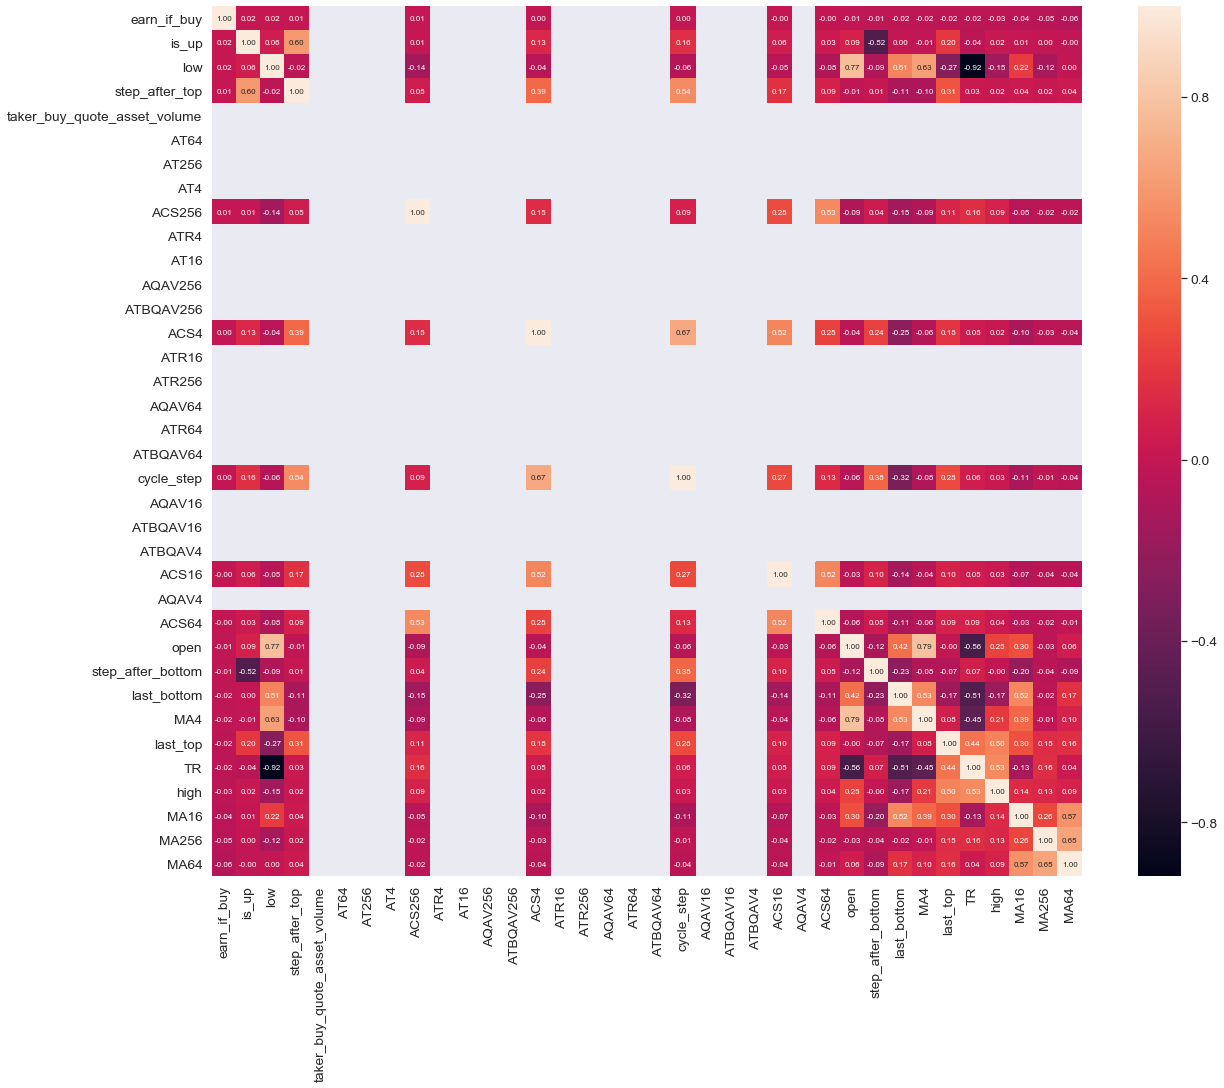

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

target_name = 'earn_if_buy'

def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corrmat, vmax=.8, square=True)

def heatmap_font(pd_data, k=-1, target=target_name):
    # k is the number of variables for heatmap
    if k == -1:
        k = pd_data.shape[1]
        
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(20, 16))
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25) # type: ignore
    hm = sns.heatmap(cm,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 8}, 
                     yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()
    

# heatmap(full_buy)
# print(full_buy.shape[1])
heatmap_font(full_buy)